In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit
#import corner
import matplotlib as mpl
import struct
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
hubble = 0.73

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot. 
    Source code: Adrian Price-Whelan https://gist.github.com/adrn/3993992
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))

    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 1.0 - np.exp(-0.5)))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 1.0 - np.exp(-2.0)))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 1.0 - np.exp(-4.5)))
    levels = [one_sigma, two_sigma, three_sigma]

    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T

    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)

    return contour

In [3]:
def set_ticklabels(ax, size=18):
    ticklabels_x = ax.get_xticklabels()
    ticklabels_y = ax.get_yticklabels()

    for label_x in ticklabels_x:
        label_x.set_fontsize(size)
        label_x.set_family('serif')
    for label_y in ticklabels_y:
        label_y.set_fontsize(size)
        label_y.set_family('serif')

In [21]:
def main_halos(snap_data):
    id_sorted = np.argsort(snap_data['mstar'])
    id_halo_A = id_sorted[-1]
    id_halo_B = id_sorted[-2]
    main_halos_data = snap_data[[id_halo_A, id_halo_B]]
    return main_halos_data

In [5]:
def satellite_halos(halo_data, halo_center):
    tmp_halo = halo_data.copy()
    radius = halo_center['vmax']/(10.0 * 100) * 1000 # in kpc/h
    for col in list(['x','y','z']):
        tmp_halo[col] = tmp_halo[col] - halo_center[col]
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    ii = r < radius
    return halo_data[ii]

In [17]:
def load_snapshot(snap_name, boxsize=75000.0):
    dtype=[('subid','i8'),
           ('parentid','i8'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('vx', 'f8'),
           ('vy', 'f8'),
           ('vz', 'f8'),
           ('vmax', 'f8'),
           ('bmag', 'f8'),
           ('vmag', 'f8'),
           ('mstar', 'f8')]
    snap_data = np.loadtxt(snap_name, dtype=dtype)    
    # this takes into account periodic boudary conditions
    for col in list(['x','y','z']):
        if((snap_data[col].max() - snap_data[col].min()) > 0.5 * boxsize):
            snap_data[col] = (snap_data[col] - 0.5 * boxsize) % boxsize
        
    return snap_data

In [89]:
def load_obs(obs_name):
    dtype=[('name','|S20'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('delta_plus', 'f8'),
           ('delta_minus', 'f8'),
           ('vmag', 'f8'),
           ('delta_vmag', 'f8')]
    obs_data = np.loadtxt(obs_name, dtype=dtype)    
    return obs_data

In [93]:
def get_best_plane(halo_data, halo_center, bright=True, all_points=False ,plotting=False, unit_vector=np.array([1.0,0.0,0.0])):
    
    if all_points==False:
        satellite_data = satellite_halos(halo_data, halo_center)
    else:
        satellite_data = halo_data.copy()
        
    if bright:
        ii = satellite_data['vmag'] < -9.0
        subset_satellite_data = satellite_data[ii]
    else:
        subset_satellite_data = satellite_data.copy()   

    
    #create vectors defining the planes
    n_vectors = 1000
    costheta = (np.random.random(n_vectors)-0.5)*2.0
    theta = np.cos(costheta)
    phi = np.random.random(n_vectors) * 2.0 * np.pi
    unit_vectors = np.zeros((n_vectors,3))
    unit_vectors[:,0] = np.sin(theta) * np.cos(phi)
    unit_vectors[:,1] = np.sin(theta) * np.sin(phi)
    unit_vectors[:,2] = np.cos(theta)

    #create arrays storing distances to all planes
    n_satellites = len(subset_satellite_data)
    pos_satellites = np.zeros((n_satellites,3))

    col = list(['x','y','z'])
    for i in range(3):
        pos_satellites[:,i] = subset_satellite_data[col[i]] - halo_center[col[i]]
    pos_satellites = np.transpose(pos_satellites)
    
    # find distances of all points to all planes
    distances_to_planes = np.dot(unit_vectors, pos_satellites)
    percentiles = np.percentile(distances_to_planes, [16,50,84], axis=1)
    delta_plane = percentiles[2,:]-percentiles[0,:]
    
    # the best plane is the one with the minimum width
    i_min = np.argmin(delta_plane)
    
    #i_min = np.argmax(delta_plane)
    
    #id_sorted = np.argsort(delta_plane)
    #n = len(id_sorted)
    #i_min = id_sorted[int(n/2)]
    #print i_min
    plane_delta = delta_plane[i_min]
    plane_center = percentiles[1,i_min]
    plane_vector = unit_vectors[i_min,:]
    
    if plotting:
        plt.scatter(delta_plane, percentiles[1,:])
    #print("plane vector", plane_vector)
    return plane_delta, plane_center, plane_vector, delta_plane, np.fabs(np.dot(plane_vector,unit_vector))

In [96]:
def inertiaTensor(x,y,z, unit_vector=np.array([1.0,0.0,0.0])):
    I=[]
    for index in range(9):
        I.append(0)
   
    I[0] = np.sum(y*y+z*z) 
    I[1] = np.sum(-y*x)    
    I[2] = np.sum(-x*z)    
    I[3] = np.sum(-y*x)    
    I[4] = np.sum(x*x+z*z) 
    I[5] = np.sum(-y*z)    
    I[6] = np.sum(-z*x)    
    I[7] = np.sum(-z*y)    
    I[8] = np.sum(x*x+y*y) 

    tensor = np.array([(I[0:3]), (I[3:6]), (I[6:9])])
    vals, vects = np.linalg.eig(tensor)  # they come out unsorted, so the command below is needed
    eig_ord = np.argsort(vals)  # a thing to note is that here COLUMN i corrensponds to eigenvalue i.
    ord_vals = vals[eig_ord]
    ord_vects = vects[:, eig_ord].T

    TriaxParam = (ord_vals[2]**2  - ord_vals[1]**2)/(ord_vals[2]**2 - ord_vals[0]**2)
    AxisRatio = ord_vals[0]/ord_vals[2]
    return ord_vals, np.fabs(np.dot(ord_vects[2],unit_vector)), TriaxParam, AxisRatio, ord_vects

def inertiaTensorHalo(halo_data, halo_center, unit_vector=np.array([1.0,0.0,0.0]), n_samples=1, items_per_sample=1):
    x = halo_data['x'] - halo_center['x']
    y = halo_data['y'] - halo_center['y']
    z = halo_data['z'] - halo_center['z']
    if(n_samples==1):
        return inertiaTensor(x,y,z,unit_vector=unit_vector)
    else:
        tmp_triax = np.zeros(n_samples)
        tmp_axis_ratio = np.zeros(n_samples)
        for i in range(n_samples):
            x_tmp = np.random.choice(x, items_per_sample)
            y_tmp = np.random.choice(y, items_per_sample)
            z_tmp = np.random.choice(z, items_per_sample)
            dd, dd, tmp_triax[i], tmp_axis_ratio[i], vv = inertiaTensor(x_tmp,y_tmp,z_tmp,unit_vector=unit_vector)
        return dd, dd, np.median(tmp_triax), np.median(tmp_axis_ratio),vv

In [97]:
def gen_random_sphere(n_points):
    """
    Sets of points in the sphere
    """
    r = np.random.random(n_points)**(1.0/3.0)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [98]:
def sample_cos_ABX(N_points_A=21, N_points_B=32):
    """
    Sample the tensor alignment between two spheres sampled with
    different number of points.
    """
    x, y, z = gen_random_sphere(N_points_A)
    eigenval, _ , triax, axis_ratio, eigenvec = inertiaTensor(x,y,z)
    main_eigenvec_A = eigenvec[2]/sum(eigenvec[2]**2)

    x, y, z = gen_random_sphere(N_points_B)
    eigenval, _, triax, axis_ratio, eigenvec = inertiaTensor(x,y,z)
    main_eigenvec_B = eigenvec[2]/sum(eigenvec[2]**2)

    cos_AB = abs(sum(main_eigenvec_A * main_eigenvec_B))
    cos_AX = abs(main_eigenvec_A[0])
    cos_BX = abs(main_eigenvec_B[0])
    return cos_AB, cos_AX, cos_BX

In [99]:
def sample_pairs(list_N_points_A=list([10]), list_N_points_B=list([20])):
    """
    Sample lists of pairs and get the median of their alignments.
    """
    M = len(list_N_points_A)
    cos_AB_array = np.zeros(M)
    cos_AX_array = np.zeros(M)
    cos_BX_array = np.zeros(M)

    for i in range(M):
        cos_AB_array[i], cos_AX_array[i], cos_BX_array[i] = \
            sample_cos_ABX(N_points_A = list_N_points_A[i], N_points_B = list_N_points_B[i])
        
    cos_AB_array.sort()
    cos_AX_array.sort()
    cos_BX_array.sort()
    return np.median(cos_AB_array), np.median(cos_AX_array), np.median(cos_BX_array)

In [100]:
def monte_carlo_sample_pairs(n_monte_carlo=1000, list_N_points_A=list([10]), list_N_points_B=list([20])):
    median_AB = np.zeros(n_monte_carlo)
    median_AX = np.zeros(n_monte_carlo)
    median_BX = np.zeros(n_monte_carlo)

    for i in range(n_monte_carlo):
        m_AB, m_AX, m_BX = sample_pairs(list_N_points_A=list_N_points_A, list_N_points_B=list_N_points_B)
        median_AB[i] = m_AB
        median_AX[i] = m_AX
        median_BX[i] = m_BX
    return median_AB, median_AX, median_BX


In [101]:
MW_data = load_obs("../data/obs/MW_satellites.txt")
M31_data = load_obs("../data/obs/M31_satellites.txt")

r_LG = np.zeros(3)
r_LG[0] = MW_data['x'][0] - M31_data['x'][0]
r_LG[1] = MW_data['y'][0] - M31_data['y'][0]
r_LG[2] = MW_data['z'][0] - M31_data['z'][0]
r_LG = r_LG/np.sqrt(np.sum(r_LG**2))

n_iter = 100
n_MW_iter = np.ones(n_iter)
MW_plane_delta_iter = np.ones(n_iter)
MW_dot_product_iter = np.ones(n_iter)
n_M31_iter = np.ones(n_iter)
M31_plane_delta_iter = np.ones(n_iter)
M31_dot_product_iter = np.ones(n_iter)

tmp_MW_bmag = np.zeros(len(MW_data))
tmp_M31_bmag = np.zeros(len(M31_data))

for i in range(n_iter):
    n = len(MW_data)
    for j in range(n):
        tmp_MW_bmag[j] = np.random.normal(loc=MW_data['vmag'][j], scale=MW_data['delta_vmag'][j])
        
    n = len(M31_data)
    for j in range(n):
        tmp_M31_bmag[j] = np.random.normal(loc=M31_data['vmag'][j], scale=M31_data['delta_vmag'][j])
    
    ii = tmp_MW_bmag<-9.0
    n_MW = len(MW_data[ii])
    MW_plane_delta, MW_plane_center, MW_plane_vector,_,_ = get_best_plane(MW_data, MW_data[0], all_points=True)
    _,dot_product_r_MW, triax_MW, axratio_MW,_ = \
        inertiaTensorHalo(MW_data[ii], MW_data[0], unit_vector=r_LG)
    
    ii = tmp_M31_bmag<-9.0
    n_M31 = len(M31_data[ii])
    M31_plane_delta, M31_plane_center, M31_plane_vector,_,_ = get_best_plane(M31_data, M31_data[0], all_points=True)
    _,dot_product_r_M31, triax_M31, axratio_M31,_ = \
        inertiaTensorHalo(M31_data[ii], M31_data[0], unit_vector=r_LG)
    
    
    n_MW_iter[i] = n_MW
    MW_plane_delta_iter[i] = MW_plane_delta
    MW_dot_product_iter[i] = dot_product_r_MW
    n_M31_iter[i] = n_M31
    M31_plane_delta_iter[i] = M31_plane_delta
    M31_dot_product_iter[i] = dot_product_r_M31

print(n_MW_iter.mean(), n_MW_iter.std())
print(MW_plane_delta_iter.mean(),MW_plane_delta_iter.std())
print(n_M31_iter.mean(), n_M31_iter.std())
print(M31_plane_delta_iter.mean(), M31_plane_delta_iter.std())

10.97 0.92146622293
50.5423962187 0.31504465067
20.93 1.22682517092
127.603131251 1.02012806984


In [102]:
#plt.scatter(M31_dot_product_iter, MW_dot_product_iter)
M31_dot_product = np.percentile(M31_dot_product_iter, [16,50,84])
MW_dot_product = np.percentile(MW_dot_product_iter, [16,50,84])
print(MW_dot_product)
print(M31_dot_product)

[ 0.87185513  0.88514944  0.90807571]
[ 0.98694217  0.99715396  0.99987336]


In [193]:
n_pairs = 19
v_circ_A = np.zeros(n_pairs)
v_circ_B = np.zeros(n_pairs)
v_circ_C = np.zeros(n_pairs)
distance_AB = np.zeros(n_pairs)
velocity_AB = np.zeros(n_pairs)
radial_vel_AB = np.zeros(n_pairs)
n_bright = np.zeros(n_pairs)
n_total = np.zeros(n_pairs)
n_bright_A = np.zeros(n_pairs)
n_bright_B = np.zeros(n_pairs)
n_dark_A  = np.zeros(n_pairs)
n_dark_B = np.zeros(n_pairs)
distance_radius_ratio = np.zeros(n_pairs)
triax_bright_A = np.zeros(n_pairs)
triax_bright_B = np.zeros(n_pairs)
axratio_bright_A = np.zeros(n_pairs)
axratio_bright_B = np.zeros(n_pairs)
triax_dark_A = np.zeros(n_pairs)
triax_dark_B = np.zeros(n_pairs)
axratio_dark_A = np.zeros(n_pairs)
axratio_dark_B = np.zeros(n_pairs)
axratio_dark_sampled_A = np.zeros(n_pairs)
axratio_dark_sampled_B = np.zeros(n_pairs)
r_AB = np.zeros((n_pairs,3))
dot_product_bright_AB = np.zeros(n_pairs)
dot_product_r_bright_A = np.zeros(n_pairs)
dot_product_r_bright_B = np.zeros(n_pairs)
dot_product_r_dark_A = np.zeros(n_pairs)
dot_product_r_dark_B = np.zeros(n_pairs)
dot_product_plane_bright_A = np.zeros(n_pairs)
dot_product_plane_bright_B = np.zeros(n_pairs)
dot_product_plane_dark_A = np.zeros(n_pairs)
dot_product_plane_dark_B = np.zeros(n_pairs)
plane_width_bright_A = np.zeros(n_pairs)
plane_width_dark_A = np.zeros(n_pairs)
plane_width_bright_B = np.zeros(n_pairs)
plane_width_dark_B = np.zeros(n_pairs)
dot_product_shape_A = np.zeros(n_pairs)
dot_product_shape_B = np.zeros(n_pairs)
dot_product_r_tweb_e3 = np.zeros(n_pairs)
dot_product_tweb_shape_bright_A = np.zeros(n_pairs)
dot_product_tweb_shape_bright_B = np.zeros(n_pairs)
dot_product_tweb_shape_dark_A = np.zeros(n_pairs)
dot_product_tweb_shape_dark_B = np.zeros(n_pairs)
tweb_environment = dict()
delta_env = np.zeros(n_pairs)
for i in range(n_pairs):
    filename = "../data/mstar_selected/Illustris_group_{}.dat".format(i)
    data = load_snapshot(filename)
    main_h_data = main_halos(data)
    print('mstar', main_h_data['mstar'][0], main_h_data['mstar'][1])
    satellite_data_A = satellite_halos(data, main_h_data[0])
    satellite_data_B = satellite_halos(data, main_h_data[1])
    
    
    v_circ_A[i] = main_h_data['vmax'][0]
    v_circ_B[i] = main_h_data['vmax'][1]

    
    r_AB[i][0] = main_h_data['x'][1] - main_h_data['x'][0]
    r_AB[i][1] = main_h_data['y'][1] - main_h_data['y'][0]
    r_AB[i][2] = main_h_data['z'][1] - main_h_data['z'][0]
    distance_AB[i] =  np.sqrt(np.sum(r_AB[i]**2))

    r_AB[i] = r_AB[i]/np.sqrt(np.sum(r_AB[i]**2))
    if(distance_AB[i]>1500.0):
        print('\n', distance_AB[i], i, '\n')
    hubble_x = 100*hubble*(main_h_data['x'][0] - main_h_data['x'][1])/1000 # km/s
    hubble_y = 100*hubble*(main_h_data['y'][0] - main_h_data['y'][1])/1000 # km/s
    hubble_z = 100*hubble*(main_h_data['z'][0] - main_h_data['z'][1])/1000 # km/s

    print(hubble_x, hubble_y, hubble_z)
    velocity_AB[i] = np.sqrt((main_h_data['vx'][0] - main_h_data['vx'][1] + hubble_x)**2 \
                    + (main_h_data['vy'][0] - main_h_data['vy'][1] + hubble_y)**2 \
                    + (main_h_data['vz'][0] - main_h_data['vz'][1] + hubble_z)**2)
    
    radial_vel_AB[i] = (main_h_data['vx'][0] - main_h_data['vx'][1] + hubble_x)*(main_h_data['x'][0] - main_h_data['x'][1])
    radial_vel_AB[i] += (main_h_data['vy'][0] - main_h_data['vy'][1] + hubble_x)*(main_h_data['y'][0] - main_h_data['y'][1])
    radial_vel_AB[i] += (main_h_data['vz'][0] - main_h_data['vz'][1] + hubble_x)*(main_h_data['z'][0] - main_h_data['z'][1])
    radial_vel_AB[i] = radial_vel_AB[i]/distance_AB[i]
    
    
    #best planes
    plane_width_bright_A[i], _, _ , _, dot_product_plane_bright_A[i] = \
        get_best_plane(data, main_h_data[0], bright=True, unit_vector=r_AB[i])
    plane_width_dark_A[i], _, _ , _ , dot_product_plane_dark_A[i] = \
        get_best_plane(data, main_h_data[0], bright=False, unit_vector=r_AB[i])
    plane_width_bright_B[i], _, _ , _, dot_product_plane_bright_B[i] = \
        get_best_plane(data, main_h_data[1], bright=True, unit_vector=r_AB[i])
    plane_width_dark_B[i], _, _ , _, dot_product_plane_dark_B[i] = \
        get_best_plane(data, main_h_data[1], bright=False, unit_vector=r_AB[i])

    # alignments with the vector joining the two halos    
    ii = satellite_data_A['vmag'] < -9.0
    n_bright_A[i] = len(satellite_data_A[ii])
    n_dark_A[i] = len(satellite_data_A)
    _,dot_product_r_bright_A[i],triax_bright_A[i],axratio_bright_A[i], unit_vectors_bright_A = \
        inertiaTensorHalo(satellite_data_A[ii], main_h_data[0], unit_vector=r_AB[i])
        
    _,dot_product_r_dark_A[i],triax_dark_A[i],axratio_dark_A[i], unit_vectors_dark_A = \
        inertiaTensorHalo(satellite_data_A, main_h_data[0], unit_vector=r_AB[i])
        
    _,_,_,axratio_dark_sampled_A[i], _ = \
        inertiaTensorHalo(satellite_data_A, main_h_data[0], unit_vector=r_AB[i], 
                          n_samples=1000, items_per_sample=int(n_bright_A[i]))
    
    dot_product_shape_A[i] = np.fabs(np.dot(unit_vectors_bright_A[0], unit_vectors_dark_A[0]))
    
    
    ii = satellite_data_B['vmag'] < -9.0
    n_bright_B[i] = len(satellite_data_B[ii])
    n_dark_B[i] = len(satellite_data_B)
    _,dot_product_r_bright_B[i],triax_bright_B[i],axratio_bright_B[i], unit_vectors_bright_B = \
        inertiaTensorHalo(satellite_data_B[ii], main_h_data[1], unit_vector=r_AB[i])
    
    _,dot_product_r_dark_B[i],triax_dark_B[i],axratio_dark_B[i], unit_vectors_dark_B = \
        inertiaTensorHalo(satellite_data_B, main_h_data[1], unit_vector=r_AB[i])
    
    _,_,_,axratio_dark_sampled_B[i], _ = \
        inertiaTensorHalo(satellite_data_B, main_h_data[1], unit_vector=r_AB[i], 
                          n_samples=1000, items_per_sample=int(n_bright_B[i]))
                          
    dot_product_shape_B[i] = np.fabs(np.dot(unit_vectors_bright_B[0], unit_vectors_dark_B[0]))
    dot_product_bright_AB[i] = np.fabs(np.dot(unit_vectors_bright_A[0], unit_vectors_bright_B[0]))
    
    
    
    n_total[i] = len(data)
    ii = data['vmag'] < 0
    n_bright[i] = len(data[ii])

mstar 7.627908 2.500447
20.013548819 20.72472847 30.048054651
mstar 5.431979 3.656405
-7.716613263 -24.120369095 -31.657913212
mstar 5.455789 1.472944
-28.234175763 -46.438693405 -26.811317433
mstar 7.381198 2.313223
54.007738263 -4.004449237 -37.690242151
mstar 4.589331 4.278156
-14.438316388 9.109316461 -24.771986805
mstar 6.440929 5.226757
27.049921802 -52.767878888 -29.374373056
mstar 3.395247 3.225855
-32.440230414 -19.728071734 -60.130613263
mstar 5.786866 4.090054
-44.319269586 -16.106692114 20.400078125
mstar 6.544223 4.266023
-11.213199237 -1.347363336 60.071585901
mstar 3.666521 3.294355
-17.934474655 66.11932222 29.123863263
mstar 6.460582 2.922932
2.780130905 -9.274707013 27.784912082
mstar 2.518358 2.008979
-11.29446875 22.227359302 11.731898401


/Users/forero/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in double_scalars
/Users/forero/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in double_scalars
/Users/forero/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


mstar 1.494109 0.853785
-29.677351526 -15.808777289 -15.905160138
mstar 1.36778 0.961931
34.890578125 -45.670339862 43.605024446
mstar 2.168645 1.910652
23.241945276 20.94871875 -7.321671948
mstar 1.164485 0.791704
-50.817695349 -36.216127017 27.782256634
mstar 2.713434 2.059742
18.125957013 -13.581992224 43.510744654
mstar 1.469479 1.258339
32.537753888 55.662143541 -0.899240207
mstar 1.369517 1.027508
1.134921875 -11.902421875 46.719714862


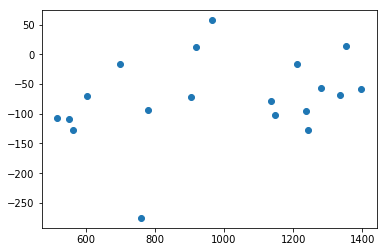

In [154]:
plt.scatter(distance_AB/hubble, radial_vel_AB)

In [155]:
MW_data = load_obs("../data/obs/MW_satellites.txt")
M31_data = load_obs("../data/obs/M31_satellites.txt")

MW_plane_delta, MW_plane_center, MW_plane_vector,_,_ = get_best_plane(MW_data, MW_data[0], all_points=True)
M31_plane_delta, M31_plane_center, M31_plane_vector,_,_ = get_best_plane(M31_data, M31_data[0], all_points=True)


ii = MW_data['vmag']<-9.0
n_MW = len(MW_data[ii])
ii = M31_data['vmag']<-9.0
n_M31 = len(M31_data[ii])

r_LG = np.zeros(3)
r_LG[0] = MW_data['x'][0] - M31_data['x'][0]
r_LG[1] = MW_data['y'][0] - M31_data['y'][0]
r_LG[2] = MW_data['z'][0] - M31_data['z'][0]
r_LG = r_LG/np.sqrt(np.sum(r_LG**2))


ii = MW_data['vmag'] < -9.0
_,dot_product_r_MW, triax_MW, axratio_MW, vectors_MW= \
        inertiaTensorHalo(MW_data[ii], MW_data[0], unit_vector=r_LG)

ii = M31_data['vmag'] < -9.0
_,dot_product_r_M31, triax_M31, axratio_M31, vectors_M31 = \
        inertiaTensorHalo(M31_data[ii], M31_data[0], unit_vector=r_LG)

print(n_MW, n_M31)
print(MW_plane_delta, M31_plane_delta)
print(dot_product_r_MW, dot_product_r_M31)

11 21
50.2628435122 126.859032347
0.885149444201 0.999925833354


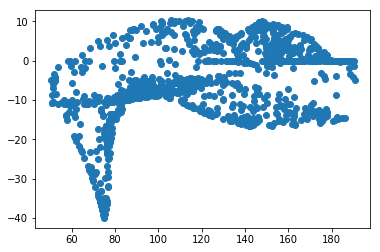

In [156]:
MW_plane_delta, MW_plane_center, MW_plane_vector, MW_widths,_ = get_best_plane(MW_data, MW_data[0], all_points=True, plotting=True)

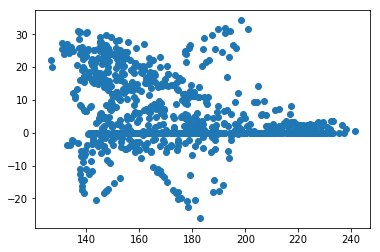

In [157]:
M31_plane_delta, M31_plane_center, M31_plane_vector, M31_widths,_ = get_best_plane(M31_data, M31_data[0], all_points=True, plotting=True)

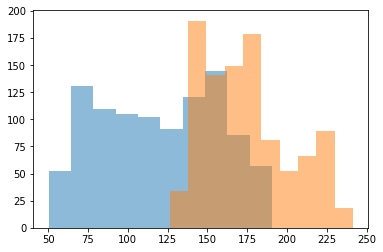

In [158]:
a= plt.hist(MW_widths, alpha=0.5)
a= plt.hist(M31_widths, alpha=0.5)

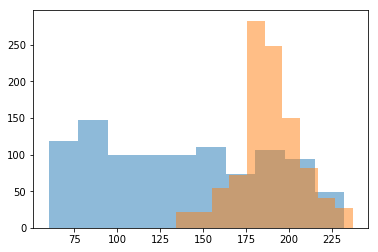

In [159]:
i = 10
filename = "../data/mstar_selected/Illustris_group_{}.dat".format(i)
data = load_snapshot(filename)
main_h_data = main_halos(data)
_, _, _ , p_widths_bright,_ =get_best_plane(data, main_h_data[0], bright=True)
_, _, _ , p_widths_dark,_ =get_best_plane(data, main_h_data[0], bright=False)
a= plt.hist(p_widths_bright, alpha=0.5)
a= plt.hist(p_widths_dark, alpha=0.5)

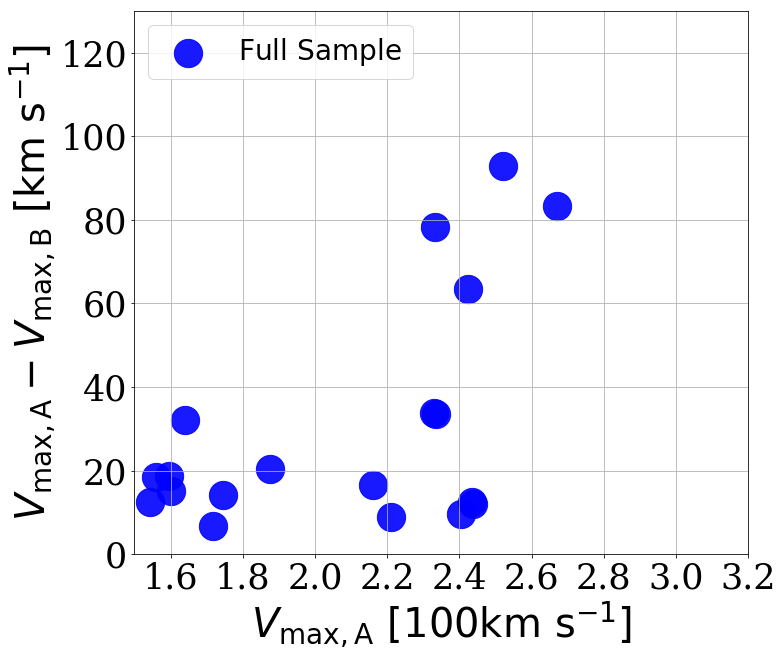

In [160]:
fig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(v_circ_A/100, v_circ_A - v_circ_B, label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')

ax.grid(True)

ax.set_xlim([1.5,3.2])
ax.set_ylim([0.0,130])

plt.xlabel(r'$V_{\rm{max,A}}\ [100 \rm{km\ s^{-1}}]$', size=40)
plt.ylabel(r'$V_{\rm{max,A}} - V_{\rm{max,B}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/v_circ_pairs.pdf', bbox_inches='tight')

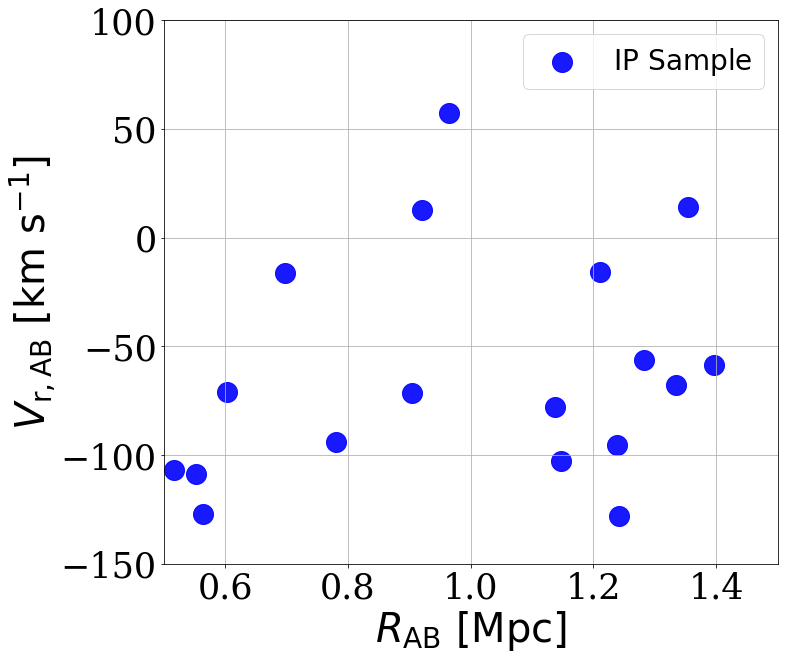

In [161]:
fig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(distance_AB/1000.0/hubble, radial_vel_AB, label='$\mathrm{IP\ Sample}$',s=400,alpha=0.9,color='b')


ax.set_xlim([0.5,1.5])
ax.set_ylim([-150,100])
ax.grid(True)


plt.xlabel(r'$R_{\rm{AB}} \ [{\rm{Mpc}}]$', size=40)
plt.ylabel(r'$V_{\rm{r,AB}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.legend(loc=1, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/v_r_pairs.pdf', bbox_inches='tight')


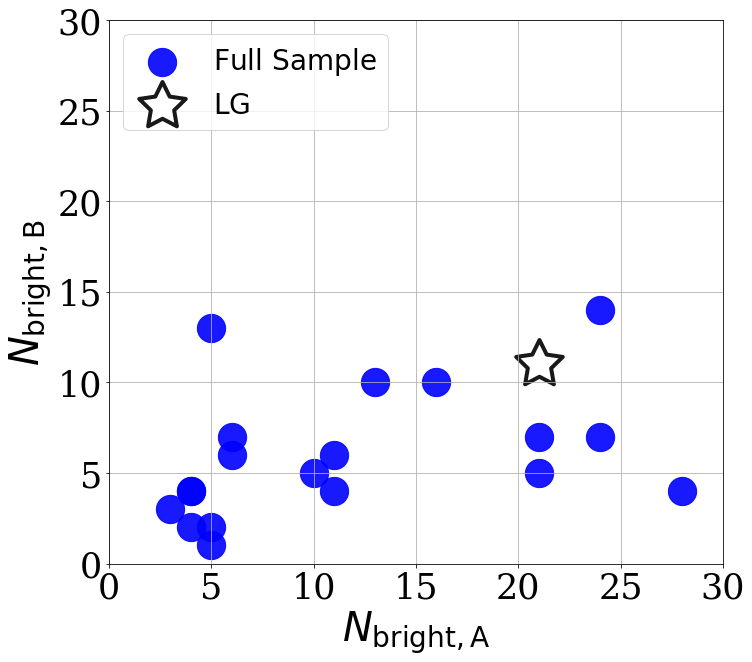

In [162]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(n_bright_A, n_bright_B,label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')

plt.scatter(n_M31, n_MW, 
            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)

ax.set_xlim([0,30])
ax.set_ylim([0,30])
ax.grid(True)


plt.xlabel(r'$N_{\rm{bright,A}}$', size=40)
plt.ylabel(r'$N_{\rm{bright,B}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/n_structure.pdf', bbox_inches='tight')

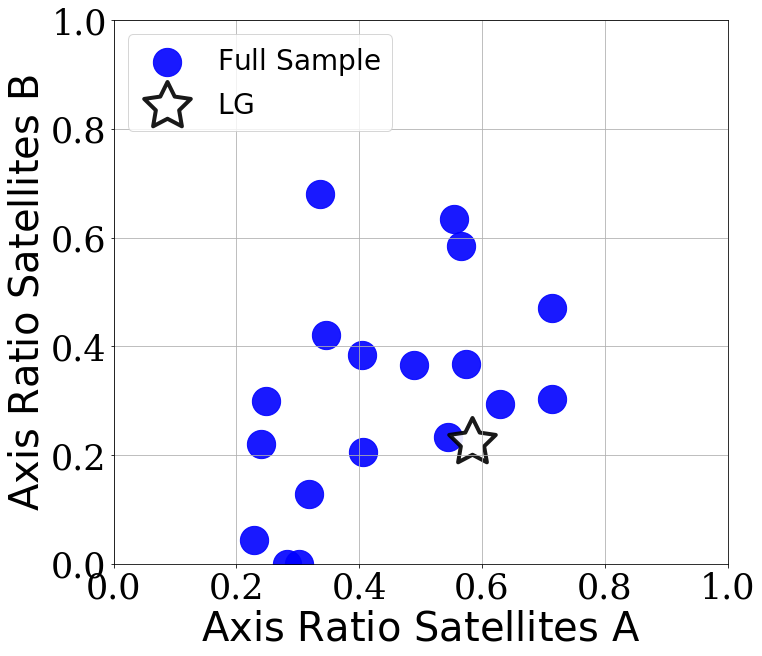

In [163]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(axratio_bright_A, axratio_bright_B,label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')


plt.scatter(axratio_M31, axratio_MW, 
            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)
            

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)


plt.xlabel(r'${\rm{Axis\ Ratio\ Satellites\ A}}$', size=40)
plt.ylabel(r'${\rm{Axis\ Ratio\ Satellites\ B}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/axratio_bright.pdf', bbox_inches='tight')

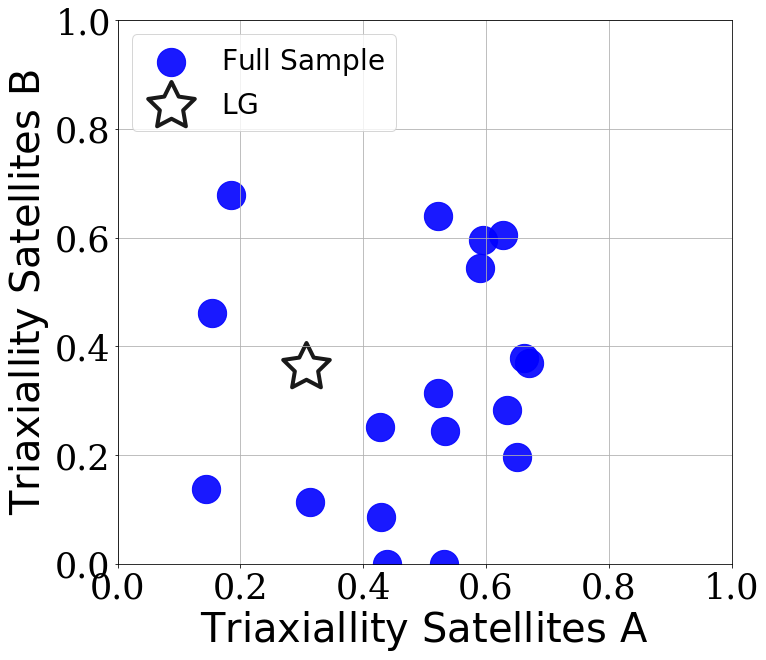

In [164]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(triax_bright_A, triax_bright_B,label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')


plt.scatter(triax_M31, triax_MW,
            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)
            
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)


plt.xlabel(r'${\rm{Triaxiallity\ Satellites\ A}}$', size=40)
plt.ylabel(r'${\rm{Triaxiallity\ Satellites\ B}}$', size=40)
plt.legend(loc=2, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/triax_bright.pdf', bbox_inches='tight')

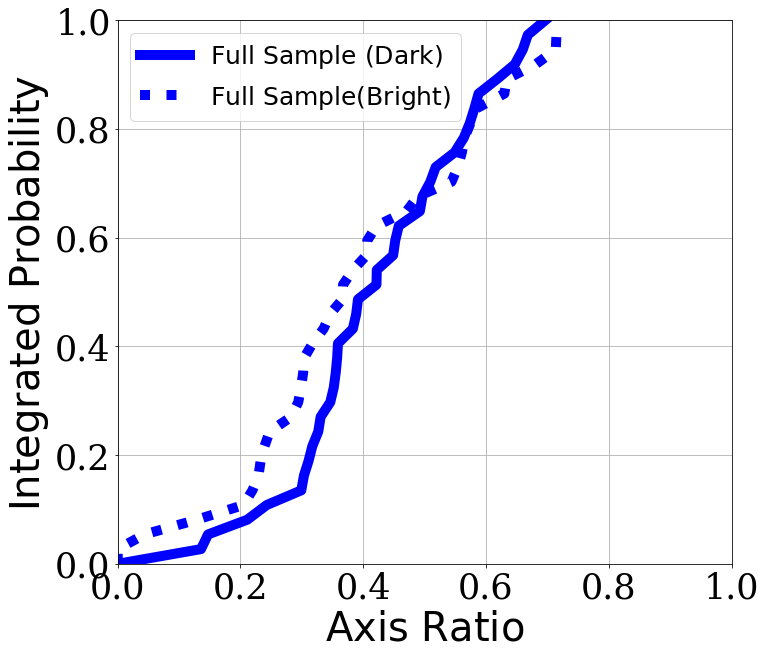

In [165]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


axratio = np.concatenate((axratio_dark_sampled_A, axratio_dark_sampled_B), axis=0)
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample\ (Dark)}$',color='b', linewidth=10, linestyle='-')

axratio = np.concatenate((axratio_bright_A, axratio_bright_B), axis=0)
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample (Bright)}$',color='b', linewidth=10, linestyle=':')



ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)


plt.xlabel(r'${\rm{Axis\ Ratio}}$', size=40)
plt.ylabel(r'${\rm{Integrated\ Probability}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/axratio_dark_bright.pdf', bbox_inches='tight')

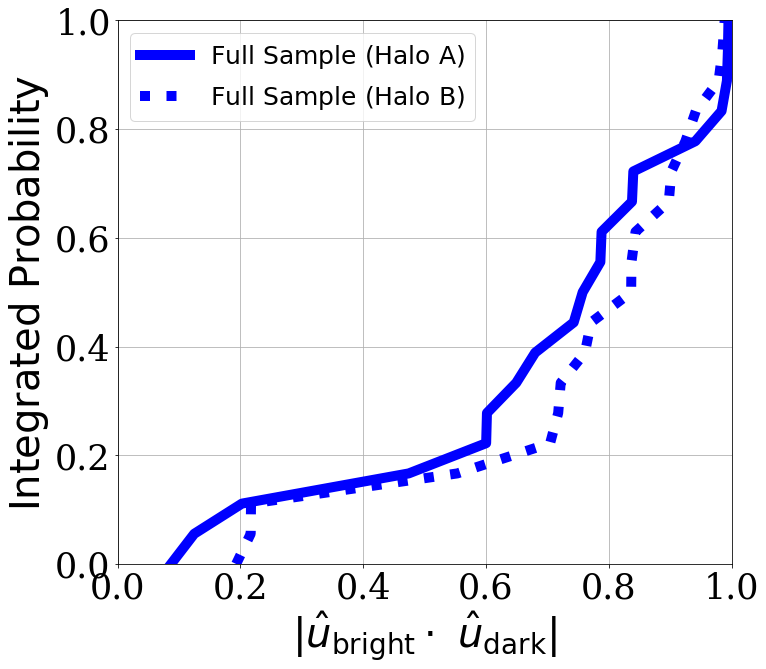

In [166]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


axratio = dot_product_shape_A
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample\ (Halo\ A)}$',color='b', linewidth=10, linestyle='-')


axratio = dot_product_shape_B
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample\ (Halo\ B)}$',color='b', linewidth=10, linestyle=':')




ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'$|\hat{u}_{\rm{bright}}\cdot\ \hat{u}_{\rm{dark}}|$', size=40)
plt.ylabel(r'${\rm{Integrated\ Probability}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/align_dark_bright.pdf', bbox_inches='tight')

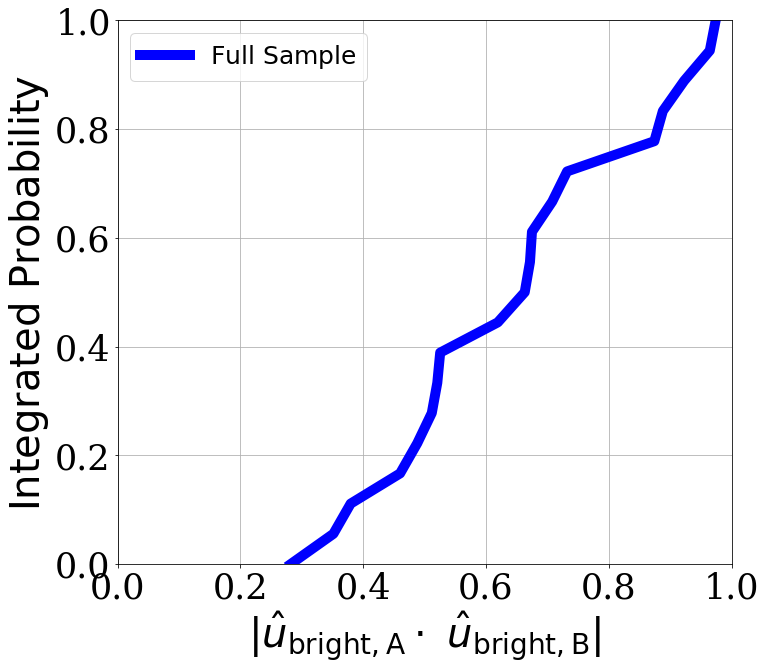

In [175]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


axratio = dot_product_bright_AB
axratio.sort()
n = len(axratio)
x = np.linspace(0.0,1.0, n)
plt.plot(axratio, x, label='$\mathrm{Full\ Sample\ }$',color='b', linewidth=10, linestyle='-')




ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'$|\hat{u}_{\rm{bright,A}}\cdot\ \hat{u}_{\rm{bright,B}}|$', size=40)
plt.ylabel(r'${\rm{Integrated\ Probability}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/align_bright_AB.pdf', bbox_inches='tight')

In [ ]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


y = np.concatenate((triax_dark_A, triax_dark_B), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Dark)}$',color='b', linewidth=10, linestyle='-')

y = np.concatenate((triax_bright_A, triax_bright_B), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Bright)}$',color='b', linewidth=10, linestyle=':')



ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)
#plt.yscale('log')
#plt.xscale('log')

plt.xlabel(r'${\rm{Triaxiality}}$', size=40)
plt.ylabel(r'${\rm{Integrated\ Probability}}$', size=40)
plt.legend(loc=4, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/triax_dark_bright.pdf', bbox_inches='tight')

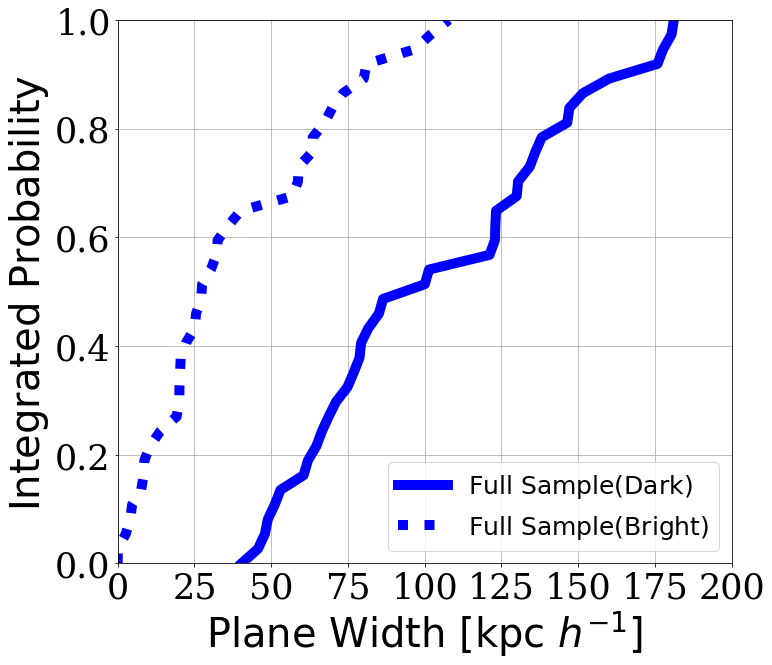

In [168]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

y = np.concatenate((plane_width_dark_A, plane_width_dark_B), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Dark)}$',color='b', linewidth=10, linestyle='-')

y = np.concatenate((plane_width_bright_A, plane_width_bright_B), axis=0)
y.sort()
n = len(y)
x = np.linspace(0.0,1.0, n)
plt.plot(y, x, label='$\mathrm{Full\ Sample (Bright)}$',color='b', linewidth=10, linestyle=':')



ax.set_xlim([0,200])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'${{\rm{Plane\ Width}\ }[{\rm{kpc}}\ h^{-1}]}$', size=40)
plt.ylabel(r'${{\rm{Integrated\ Probability}}}$', size=40)
plt.legend(loc=4, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/plane_width.pdf', bbox_inches='tight')

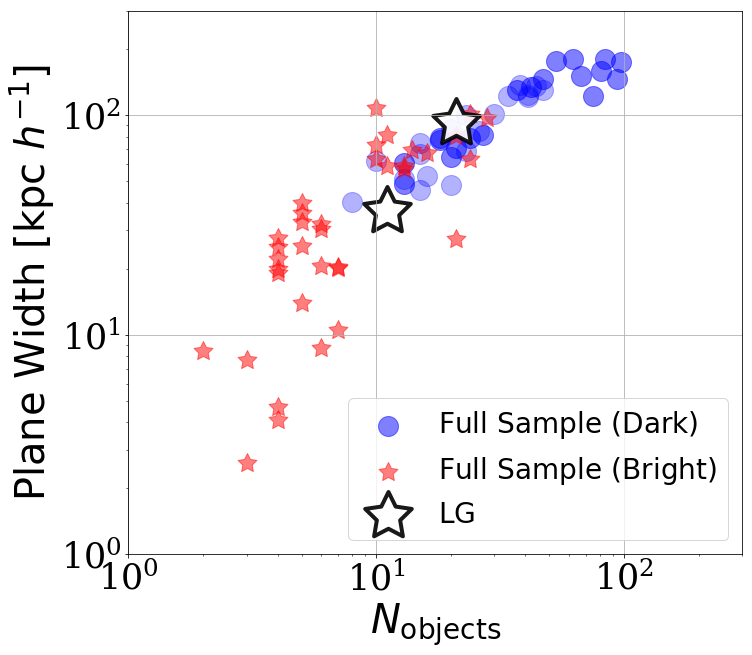

In [169]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(n_dark_A, plane_width_dark_A,
                label='$\mathrm{Full\ Sample\ (Dark)}$',s=400,alpha=0.5,color='b')
plt.scatter(n_dark_B, plane_width_dark_B,s=400,alpha=0.3,color='b')

plt.scatter(n_bright_A, plane_width_bright_A,
                label='$\mathrm{Full\ Sample\ (Bright)}$',s=400,alpha=0.5,color='red', marker=(5,1))
plt.scatter(n_bright_B, plane_width_bright_B,s=400,alpha=0.5,color='red',marker=(5,1))

hubble = 0.73
plt.scatter([n_MW, n_M31], [MW_plane_delta*hubble, M31_plane_delta*hubble],
            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)
            

ax.set_xlim([1,300])
ax.set_ylim([1,300])
ax.grid(True)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$N_{\rm{objects}}$', size=40)
plt.ylabel(r'${{\rm{Plane\ Width}}\ [{\rm{kpc}}\ h^{-1}]}$', size=40)
plt.legend(loc=4, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/plane_width_n_dark.pdf', bbox_inches='tight')

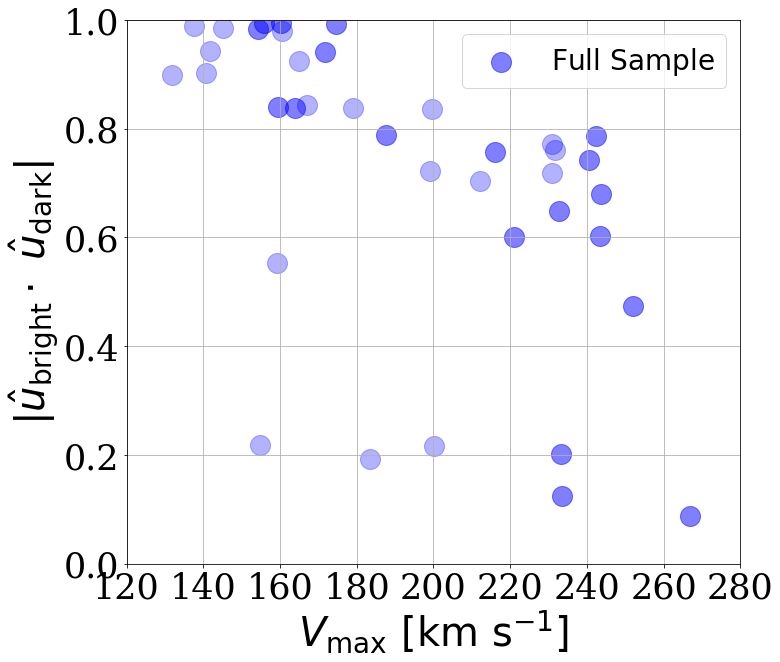

In [170]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

plt.scatter(v_circ_A, dot_product_shape_A,
                label='$\mathrm{Full\ Sample}$',s=400,alpha=0.5,color='b')
plt.scatter(v_circ_B, dot_product_shape_B,s=400,alpha=0.3,color='b')



ax.set_xlim([120,280])
ax.set_ylim([0,1])
ax.grid(True)
#plt.yscale('log')
#plt.xscale('log')

plt.ylabel(r'$|\hat{u}_{\rm{bright}}\cdot\ \hat{u}_{\rm{dark}}|$', size=40)
plt.xlabel(r'$V_{\rm{max}}\ [\rm{km\ s^{-1}}]$', size=40)
plt.legend(loc=1, prop={'size':28}, scatterpoints=1)
plt.savefig('../paper/shape_align_n_dark.pdf', bbox_inches='tight')

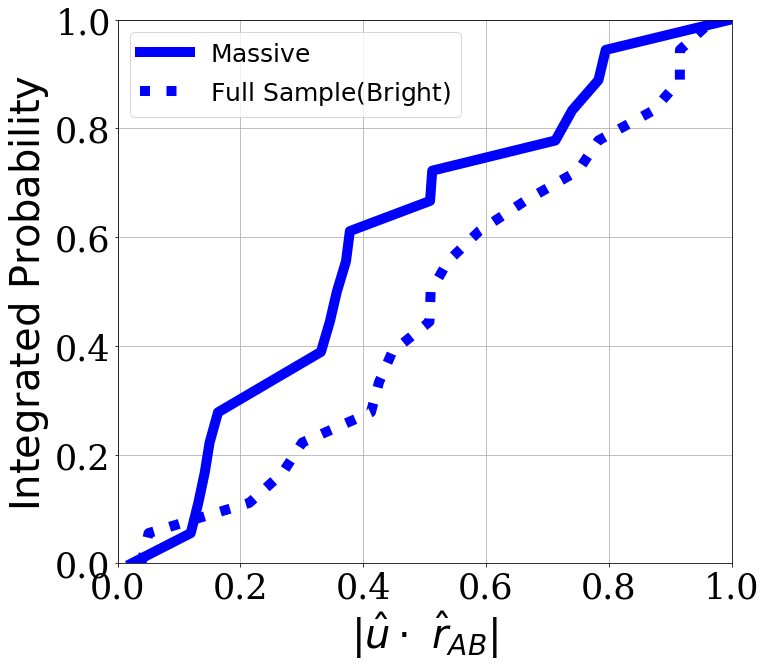

In [364]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)


x = dot_product_r_bright_A.copy()
x.sort()
n = len(x)
int_A = np.linspace(0.0,1.0, n)
plt.plot(x, int_A, label='$\mathrm{Massive}$',color='b', linewidth=10, linestyle='-')

y = dot_product_r_bright_B.copy()
y.sort()
n = len(y)
int_B = np.linspace(0.0,1.0, n)
plt.plot(y, int_B, label='$\mathrm{Full\ Sample (Bright)}$',color='b', linewidth=10, linestyle=':')


ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.grid(True)

plt.xlabel(r'$|\hat{u}\cdot\ \hat{r}_{AB}|$', size=40)
plt.ylabel(r'${{\rm{Integrated\ Probability}}}$', size=40)
plt.legend(loc=2, prop={'size':25}, scatterpoints=1)
plt.savefig('../paper/r_u_alignment_integrated.pdf', bbox_inches='tight')

In [355]:
diff_median = x[n//2] - y[n//2]
max_xy = np.max((dot_product_r_bright_A + dot_product_r_bright_B))
median_xy = np.percentile((np.sqrt(dot_product_r_bright_A**2 + dot_product_r_bright_B**2)),50)
median_diff_xy = np.median((dot_product_r_bright_A - dot_product_r_bright_B))

max_lg = (dot_product_r_M31+ dot_product_r_MW)
print(diff_median)
diff_mw = (dot_product_r_M31-dot_product_r_MW)
print(max_xy) #7/2 exponent
print(median_xy)
print(max_lg)
print(median_diff_xy)
print(diff_mw)
print(np.median(dot_product_r_bright_A), np.median(dot_product_r_bright_B))

-0.152756687322
1.45868350015
0.799179988357
1.88507527756
-0.241148122383
0.114776389153
0.357096182621 0.509852869943


In [362]:
n = 19
n_try = 100000
stat_ab = np.ones(n_try)
for i in range(n_try):
    a = np.random.random(n)
    b = np.random.random(n)
    med_a = np.percentile(a, 50)
    med_b = np.percentile(b, 50)
    max_sum = np.max((a + b))
    median_diff = np.median((a - b))
    #median_sum = np.percentile((np.sqrt(a**2 + b**2)),50)
    #stat_ab[i] = med_a - med_b
    #stat_ab[i] = median_sum
    #stat_ab[i] = max_sum
    stat_ab[i] = np.median(a)
print(100*np.count_nonzero(stat_ab<median_diff_xy)/n_try)
print(np.count_nonzero(stat_ab>diff_mw))
print(100*np.count_nonzero(stat_ab<np.median(dot_product_r_bright_A))/n_try)

0.0
100000
9.8


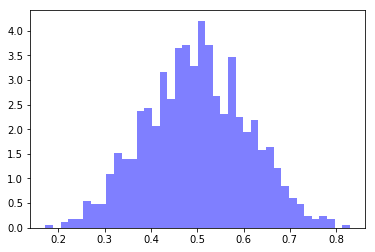

In [357]:
under = np.random.random(n_try) - np.random.random(n_try)
a = plt.hist(stat_ab, bins=40, alpha=0.5, color='blue', normed=True)
#b = plt.hist(under, bins=30,alpha=0.4, color='red', normed=True)

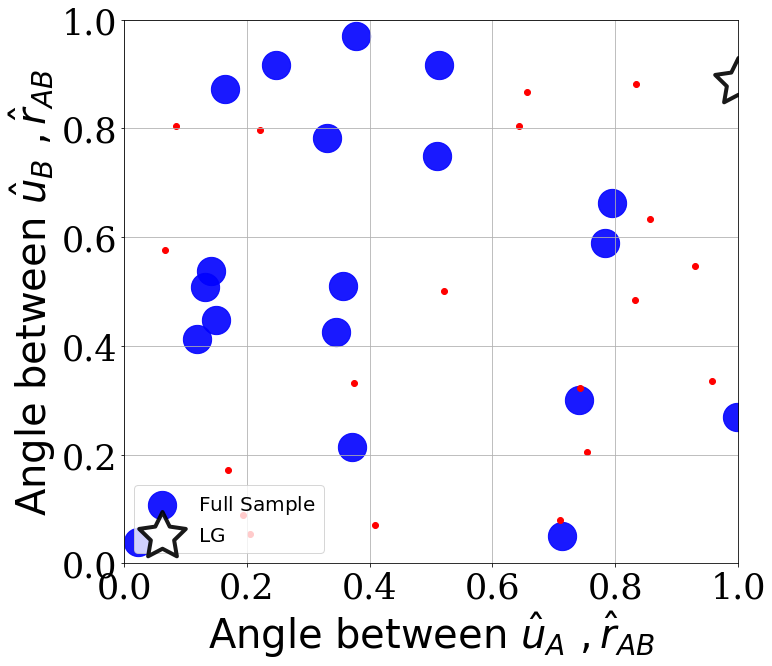

In [363]:
pfig = plt.figure(1, figsize=(11,10))
ax = plt.axes()
set_ticklabels(ax, size=35)

#plt.scatter(np.rad2deg(np.arccos(dot_product_r_bright_A)), np.rad2deg(np.arccos(dot_product_r_bright_B)),
#                label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')
#plt.scatter(np.rad2deg(np.arccos(dot_product_r_M31)), np.rad2deg(np.arccos(dot_product_r_MW)),
#            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)

plt.scatter(dot_product_r_bright_A, dot_product_r_bright_B,
                label='$\mathrm{Full\ Sample}$',s=800,alpha=0.9,color='b')
plt.scatter(dot_product_r_M31, dot_product_r_MW,
            label='$\mathrm{LG}$', s=2400,alpha=0.9,facecolors='white', edgecolors='black', marker=(5,1), linewidth=4)

plt.scatter(np.random.random(19), np.random.random(19), color='red')

#a = plt.errorbar(M31_dot_product[1], MW_dot_product[1], 
#                 xerr=[[M31_dot_product[1]-M31_dot_product[0]],[M31_dot_product[2]-M31_dot_product[1]]],
#                 yerr=[[MW_dot_product[1]-MW_dot_product[0]],[MW_dot_product[2]-MW_dot_product[1]]])

#ax.set_xlim([0,90.0])
#ax.set_ylim([0,90.0])
ax.set_xlim([0,1.0])
ax.set_ylim([0,1.0])
ax.grid(True)

plt.xlabel(r'Angle between $\hat{u}_A\ , \hat{r}_{AB}$', size=40)
plt.ylabel(r'Angle between $\hat{u}_B\ , \hat{r}_{AB}$', size=40)
plt.legend(loc=3, bbox_to_anchor=(0.0, 0.0), bbox_transform=ax.transAxes, 
           prop={'size':20}, scatterpoints=1)
plt.savefig('../paper/r_u_alignment.pdf', bbox_inches='tight')

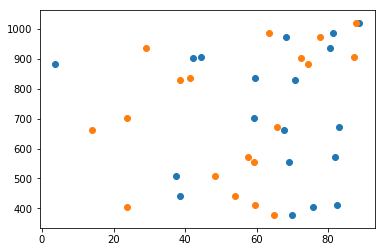

In [180]:
plt.scatter(np.rad2deg(np.arccos(dot_product_r_bright_A)),distance_AB)
plt.scatter(np.rad2deg(np.arccos(dot_product_r_bright_B)),distance_AB)

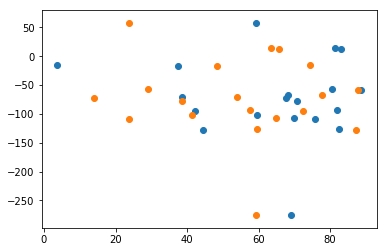

In [181]:
plt.scatter(np.rad2deg(np.arccos(dot_product_r_bright_A)),radial_vel_AB)
plt.scatter(np.rad2deg(np.arccos(dot_product_r_bright_B)),radial_vel_AB)